# funnel analysis

### Funnel analysis allows to understand where/when our users abandon the website. It gives crucial insights in user behavior and on ways to improve the user experience as well as it often allows to discover bugs.

In [1]:
import pandas
import numpy as np
import matplotlib.dates as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns 
from matplotlib import rcParams
rcParams.update({'figure.autolayout':True})
pandas.set_option('display.max_columns', 10)
pandas.set_option('display.width', 350)

In [2]:
user = pandas.read_csv('/Users/wangyuying/Desktop/Funnel_Analysis/user_table.csv')
home_page = pandas.read_csv('/Users/wangyuying/Desktop/Funnel_Analysis/home_page_table.csv')
search_page = pandas.read_csv('/Users/wangyuying/Desktop/Funnel_Analysis/search_page_table.csv')
payment_page = pandas.read_csv('/Users/wangyuying/Desktop/Funnel_Analysis/payment_page_table.csv')
payment_confirmation = pandas.read_csv('/Users/wangyuying/Desktop/Funnel_Analysis/payment_confirmation_table.csv')

In [3]:
user.head()

,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male
2,568983,2015-04-09,Desktop,Male
3,190794,2015-02-18,Desktop,Female
4,537909,2015-01-15,Desktop,Male


In [4]:
home_page.head()

,user_id,page
0,313593,home_page
1,468315,home_page
2,264005,home_page
3,290784,home_page
4,639104,home_page


In [5]:
search_page.head()

,user_id,page
0,15866,search_page
1,347058,search_page
2,577020,search_page
3,780347,search_page
4,383739,search_page


In [6]:
# join all of them one user_id
data = pandas.merge(user,home_page,on = 'user_id')
data = pandas.merge(data, search_page, how = 'left', on='user_id',suffixes = ('_home','_search'))
data = pandas.merge(data,payment_page,how ='left',on ='user_id')
data = pandas.merge(data,payment_confirmation,how ='left',on ='user_id', suffixes = ('_payment', '_comfirmation'))

In [7]:
# replace Nas with 0 and non-Nas with 1
for i  in range(4,8):
    data.iloc[:,i] = np.where(data.iloc[:,i].isna(),0,1)# act on each column

In [12]:
#make it a date 
data['date'] = pandas.to_datetime(data['date'])

In [14]:
data.describe()

,user_id,page_home,page_search,page_payment,page_comfirmation
count,90400.000000,90400.0,90400.000000,90400.000000,90400.000000
mean,498709.683473,1.0,0.500000,0.066704,0.005000
std,289040.674085,0.0,0.500003,0.249509,0.070534
min,17.000000,1.0,0.000000,0.000000,0.000000
25%,247978.750000,1.0,0.000000,0.000000,0.000000
50%,498267.000000,1.0,0.500000,0.000000,0.000000
75%,749789.250000,1.0,1.000000,0.000000,0.000000
max,999979.000000,1.0,1.000000,1.000000,1.000000


In [15]:
# check data reliability. Are user_ids unique?
data['user_id'].nunique() == len(data)

True

In [16]:
# Anyone who made it to a given step of the funnel also made it to the prior steps?
(data['page_search']>= data['page_payment']).unique()#check payment vs search page

array([ True])

In [19]:
(data['page_payment']>= data['page_comfirmation']).unique()

array([ True])

In [20]:
# Full picture of funnel conversion rate for both desktop and mobile 
data.groupby('device')['page_comfirmation'].agg({'mean','count'})

,mean,count
device,,
Desktop,0.002492,60200
Mobile,0.010000,30200


#### 1 Mobile conversion rate is ~4 times higher that desktop
#### 2 Desktop has ~2x the number of users 
#### 3 The value of conversion rate seems low compared to industry standars. Obviously conversion rate depend on many things, such as item price, how popular is the site, main geography, etc. However, conversion rate significatly lower than 1% is pretty low for most on-line businesses.

In [21]:
# Let's now check the entire funnel
data.groupby('device').apply(lambda x: pandas.Series({
    'to_search': x['page_search'].mean()/x['page_home'].mean(),
    "tp_payment":x['page_payment'].mean()/x['page_search'].mean(),
    'to_comfirmation':x['page_comfirmation'].mean()/x['page_payment'].mean()
}))#看有多少到了下一级

,to_search,tp_payment,to_comfirmation
device,,,
Desktop,0.5,0.1,0.049834
Mobile,0.5,0.2,0.100000


#### 50% of bouners is pretty common number. However, the other two seem low. We can safely assume that peoplpe who made it to the search page have some intent to buy. However, only 1% of these people convert on desktop and 2% of mobile!

#### However, an aggreagte number is not particularly informative. Trend is way more important. A 1% conversion rate that has been growing constantly over the previous months is way better than a 2% that has been going down constantly. So let's plot funnel as a time series.

In [22]:
# Cibversion rate as a time series use mean to describe conversion rate 
cr_ts = data.groupby(['date','device'])['page_comfirmation'].mean().reset_index(name='conversion_rate')
cr_ts

,date,device,conversion_rate
0,2015-01-01,Desktop,0.002028
1,2015-01-01,Mobile,0.022831
2,2015-01-02,Desktop,0.002066
3,2015-01-02,Mobile,0.016878
4,2015-01-03,Desktop,0.005917
...,...,...,...
235,2015-04-28,Mobile,0.003846
236,2015-04-29,Desktop,0.000000
237,2015-04-29,Mobile,0.000000
238,2015-04-30,Desktop,0.000000


/Users/wangyuying/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


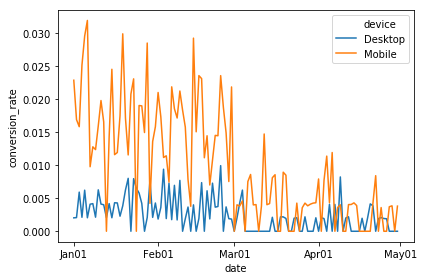

In [24]:
g = sns.lineplot(x ='date', hue = 'device', y = 'conversion_rate', data = cr_ts)
g.xaxis.set_major_locator(mdates.MonthLocator())
g.xaxis.set_major_formatter(mdates.DateFormatter('%b%d'))
plt.show()

#### It actually looks like both desktop and mobile dropped at some point around the behinning of March! Let's break down the funnel into its page-by-page steps to see if those drops are related to a given page.

In [25]:
# funnel as a time series
funnel = data.groupby(['date','device']).apply(lambda x:pandas.Series({'to_search':x['page_search'].mean()/x['page_home'].mean(),
                                                                      'to_payment':x['page_payment'].mean()/x['page_search'].mean(),
                                                                      'to_comfirmation':x['page_comfirmation'].mean()/x['page_payment'].mean()})).reset_index()

In [26]:
funnel

,date,device,to_search,to_payment,to_comfirmation
0,2015-01-01,Desktop,0.519270,0.183594,0.021277
1,2015-01-01,Mobile,0.821918,0.161111,0.172414
2,2015-01-02,Desktop,0.539256,0.168582,0.022727
3,2015-01-02,Mobile,0.784810,0.215054,0.100000
4,2015-01-03,Desktop,0.437870,0.099099,0.136364
...,...,...,...,...,...
235,2015-04-28,Mobile,0.207692,0.296296,0.062500
236,2015-04-29,Desktop,0.483444,0.018265,0.000000
237,2015-04-29,Mobile,0.200000,0.115385,0.000000
238,2015-04-30,Desktop,0.509294,0.036496,0.000000


In [27]:
#make the dataset long for the plot
funnel = pandas.melt(funnel,id_vars = ['date','device'])


In [28]:
funnel

,date,device,variable,value
0,2015-01-01,Desktop,to_search,0.519270
1,2015-01-01,Mobile,to_search,0.821918
2,2015-01-02,Desktop,to_search,0.539256
3,2015-01-02,Mobile,to_search,0.784810
4,2015-01-03,Desktop,to_search,0.437870
...,...,...,...,...
715,2015-04-28,Mobile,to_comfirmation,0.062500
716,2015-04-29,Desktop,to_comfirmation,0.000000
717,2015-04-29,Mobile,to_comfirmation,0.000000
718,2015-04-30,Desktop,to_comfirmation,0.000000


/Users/wangyuying/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


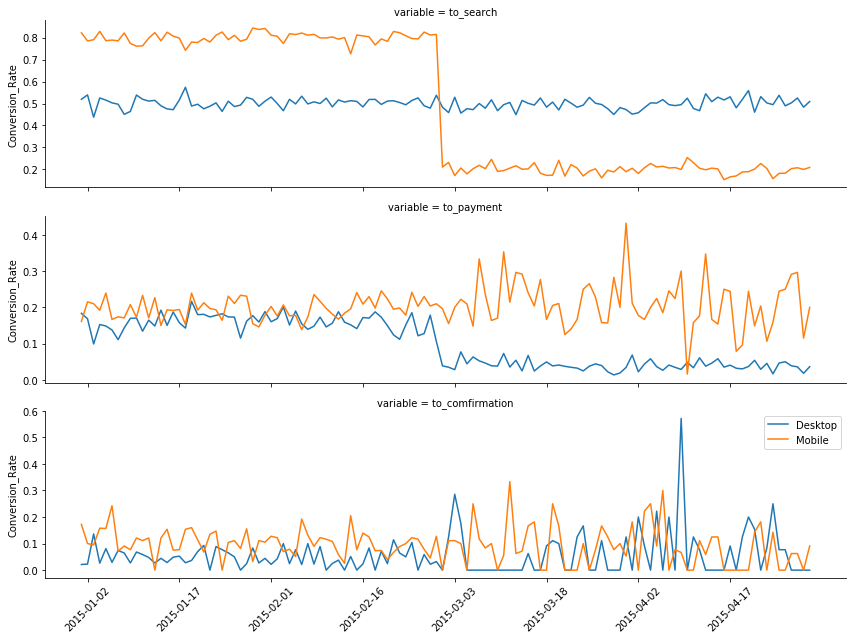

In [30]:
# plot it 
g = sns.FacetGrid(funnel,hue ='device', row ='variable', aspect =4, sharey =False)
g.map(sns.lineplot,'date','value')
g.set_axis_labels('','Conversion_Rate')
g.set(xticks = funnel.date[2::30].unique())
plt.xticks(rotation = 45)
plt.legend(loc = 'upper right')
plt.show()

#### It looks like both Desktop and Mobile dropped on March, 1st. However, this happened on different pages. Mobile had a  huge increase in number of bouncers. Desktop saw a huge increase in the percentage of people leaving the site after landing on the search page. 

### Q: Some insights on what the product team should focus on in order to improve conversion rate ?

#### The classical way to do this would be to build a machine learning model to predict conversion rate, where the features would be time-based variables, device, and sex.
#### However, in a situation as simple as this, and with so few variables, we might no need a model. We already looked at seasonailty and device in depth, The only thing left here is the variable sex. We can just look at it independently to see if it is at all informative.

In [31]:
# Overall conversion rate for variable sex
data.groupby('sex')['page_comfirmation'].agg({'mean','count'})

,mean,count
sex,,
Female,0.005347,45075
Male,0.004655,45325


#### We almost have the same number of Male and Female users. And conversion rate appears pretty similar too. Let's check if that small difference in conversion rate is statistically significant:

In [45]:
from scipy import stats
#Statistical test in conversion rate and sex
test = stats.ttest_ind(data.loc[data['sex']=='Female']['page_comfirmation'], 
                                data.loc[data['sex']!='Female']['page_comfirmation'],equal_var = False)

In [47]:
test.statistic

1.473291657657286

In [48]:
test.pvalue 

0.14067591026227633

#### It is not significant. So, overall, sex does not affect conversion rate in a statistically significnt way. Finally, let's see if sex interacts with device.

In [49]:
# interaction of sex and device 
data.groupby(['device','sex'])['page_comfirmation'].agg({'mean','count'})

count      mean
device  sex                    
Desktop Female  29997  0.002467
        Male    30203  0.002516
Mobile  Female  15078  0.011076
        Male    15122  0.008927

#### It looks like the entire difference in conversion rate between males and females comes from mobile. Hard to say more without having more varables. It could very well be noise, or  a proxy for some other variables. In any case, this is something that might lead to further anakysis, although it is certainly not a top pirority given everything else we discovered.

## Conclusions

### 1. Deaktop has way more users that mobile, but much lower conversion rate. Having less mobile visitors is pretty worrisome. Pretty much all healthy tech companies should have more mobile users than desktop. So growing mobile should be a top priority for the company as a whole

### 2. There are a couple of ways to explain the lower conversion rate on desktop: 1 Product: desktop has a worse product. So product team should look into the differences between the two to see if UX/UI can be improved on desktop 2 Marketing: the two platforms are attracting different kinds of users. So they just act as a proxy for users, who obviously convert at a much higer rate. Or desktop is spending a lot on ads and these ads are attracting lower intebnt users. If we have more data about the users, we could find out if user distribution is the same across the device(so it is most likely a product problem) or not (marketing problem). The marketing explanantion has the advantage of explaining also the strabgely lower than absolute count for mobile users.

### 3. All key metrics for both devices have actually gone down a lot in the last few months. All drops though appear to happen on specific days and one specific pages. This kind of behavior is often the sign of a bug (more likely) or bad product changes (which at the end of the day are basically bugs too, just product bugs instead of engineering bugs). Usual analysis steps to find out why a metric suddenly dropped should be done here.

### 4. It is hard to say without more information about the site, but the funnel numbers across the board do not look particualrly good. For instance, even before the bug, only at most 20% of users go from the search page to the payment page. These are clearly users with some sort of intent, It could be interesting to look into the characteristics of the search queries to see if people are constantly looking for something they can not find. essentially, trying to understnd lack of supply compared to user demand.